In [46]:
# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from PIL import ImageDraw
import datasets
from datasets import load_dataset

In [47]:
train_path= "./data/art-classification/train/"
test_path= "./data/art-classification/test/"

def load_images(path, count):
    with os.scandir(path) as files:
        images = []
        for file in files:
            # print(f"parsing file: {file.name}")
            if file.name.endswith((".jpg", ".png")):
                img = Image.open(file)
                images.append(img)
            if len(images) >= count:
                break
        return images

# art_images = load_images(art_path,1000)
# human_images = load_images(humans_path, 1000)

# class ImageDataset(Dataset):
#     def __init__(self, images, transform=None):
#         self.images = images
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx]
#         if self.transform:
#             image = self.transform(image)
#         return image

# def load_image_paths(path, count):
#     with os.scandir(path) as files:
#         image_paths = []
#         for file in files:
#             if file.name.endswith((".jpg", ".png")):
#                 image_paths.append(os.path.join(path, file.name))
#             if len(image_paths) >= count:
#                 break
#         return image_paths
def load_image_paths(path, count):
    image_paths = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith((".jpg", ".png")):
                image_paths.append(os.path.join(root, file))
            if len(image_paths) >= count:
                return image_paths
    return image_paths

def get_class_label_from_path(path, class_to_idx):
    for class_name in class_to_idx:
        if os.path.sep + class_name + os.path.sep in path:
            return class_to_idx[class_name]
    return -1  # Unknown class

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        class_names = sorted({os.path.basename(os.path.dirname(p)) for p in image_paths})
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
        self.classes = class_names  # add this line
        self.labels = [get_class_label_from_path(p, self.class_to_idx) for p in image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
        # for i in range(images.size(0)):
        #     if shown >= 20:
        #         continue
        #     ax = axes[shown]
        #     img = images[i].cpu().permute(1, 2, 0)
        #     img = img * 0.5 + 0.5  # adjust if your normalization differs
        #     ax.imshow(img.numpy())
        #     correct = '✓' if preds[i] == labels[i] else '✗'
        #     ax.set_title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]} {correct}", fontsize=8)
        #     ax.axis('off')
        #     shown += 1
        

    transforms.Resize((128,128)),
    # transforms.CenterCrop(64),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    # Example normalization for RGB images
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

train_image_paths=load_image_paths(train_path, 100000)
test_image_paths=load_image_paths(test_path,100000)


train_dataset = ImageDataset(train_image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16)

test_dataset = ImageDataset(test_image_paths, transform=transform)
test_loader = DataLoader(test_dataset,batch_size=64, shuffle=True, num_workers=16)

In [48]:
# class CNNClassifier(nn.Module):
#     def __init__(self):
#         super(CNNClassifier, self).__init__()
#         self.cnn= nn.Sequential(
#             nn.LazyConv2d(32,3,2,1), #128x128
#             nn.LazyBatchNorm2d(),
#             nn.LazyConv2d(32,3,1,1),
#             nn.LazyConv2d(32,3,1,1),
#             nn.LazyConv2d(32,3,1,1),
#             nn.LazyBatchNorm2d(),
#             nn.MaxPool2d(2,2), #64x64
#             nn.LazyConv2d(64,3,2,1), #32x32
#             nn.LazyConv2d(64,3,1,1),
#             nn.LazyConv2d(64,3,1,1),
#             nn.LazyBatchNorm2d(),
#         )

#         self.linear = nn.Sequential(
#             nn.LazyLinear(1024),
#             nn.LeakyReLU(),
#             nn.LazyLinear(128),
#             nn.Sigmoid(),
#             nn.LazyLinear(27),
#         )

#     def forward(self,x):
#         x=self.cnn(x)
#         x=x.view(x.size(0),-1)
#         return self.linear(x)

# class CNNClassifier(nn.Module):
#     def __init__(self):
#         super(CNNClassifier, self).__init__()

#         def conv_block(in_channels, out_channels):
#             return nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             )
        
#         def lazy_conv_block(out_channels):
#             return nn.Sequential(
#                 nn.LazyConv2d(out_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True),
#                 nn.LazyConv2d(out_channels,kernel_size=3, padding=1),
#                 nn.BatchNorm2d(out_channels),
#                 nn.ReLU(inplace=True)
#             )
        
#         self.lazyconv1 = lazy_conv_block(64)
#         self.lazyconv2 = lazy_conv_block(128)
#         self.lazyconv3 = lazy_conv_block(256)

#         self.enc1 = conv_block(3, 64)
#         self.enc2 = conv_block(64, 128)
#         self.enc3 = conv_block(128, 256)
#         self.enc4 = conv_block(256, 512)
#         self.center = conv_block(512, 1024)

#         self.pool = nn.MaxPool2d(2, 2)

#         self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.dec4 = conv_block(1024, 512)
#         self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.dec3 = conv_block(512, 256)
#         self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.dec2 = conv_block(256, 128)
#         self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.dec1 = conv_block(128, 64)

#         self.out_conv = nn.Conv2d(64, 27, kernel_size=1)
    
#         self.classifier = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten(),
#             nn.LazyLinear(64),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(64, 27)
#         )

# # Replace return in forward() with:

#     def forward(self, x):
#         enc1 = self.enc1(x)
#         enc2 = self.enc2(self.pool(enc1))
#         enc3 = self.enc3(self.pool(enc2))
#         enc4 = self.enc4(self.pool(enc3))
#         center = self.center(self.pool(enc4))

#         dec4 = self.dec4(torch.cat([self.up4(center), enc4], dim=1))
#         dec3 = self.dec3(torch.cat([self.up3(dec4), enc3], dim=1))
#         dec2 = self.dec2(torch.cat([self.up2(dec3), enc2], dim=1))
#         dec1 = self.dec1(torch.cat([self.up1(dec2), enc1], dim=1))

#         lazyconv1 = self.lazyconv1(dec1)
#         lazyconv2 = self.lazyconv2(lazyconv1)
#         lazyconv3 = self.lazyconv3(lazyconv2)

#         # return self.out_conv(dec1)
#         return self.classifier(lazyconv3)



class CNNClassifier(nn.Module):
    def __init__(self, num_classes=27):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.conv_block2 = nn.Sequential(
            nn.LazyConv2d(128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        self.conv_block3 = nn.Sequential(
            nn.LazyConv2d(256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x 

In [49]:
epochs = 50

device=torch.device("cuda" if torch.cuda.is_available else "cpu")

model=CNNClassifier().to(device)

# import torchvision.models as models

# model = models.resnet18(weights='IMAGENET1K_V1')
# model.fc = nn.Linear(model.fc.in_features, 27)
# model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(epochs):
    for images, labels in train_loader:
        model.train()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 3.3176
Epoch [2/50], Loss: 2.8370
Epoch [3/50], Loss: 2.7794
Epoch [4/50], Loss: 2.9458
Epoch [5/50], Loss: 2.6658
Epoch [6/50], Loss: 3.0934
Epoch [7/50], Loss: 3.8670
Epoch [8/50], Loss: 2.7030
Epoch [9/50], Loss: 3.1553
Epoch [10/50], Loss: 2.1024
Epoch [11/50], Loss: 2.5463
Epoch [12/50], Loss: 2.5619
Epoch [13/50], Loss: 2.3186
Epoch [14/50], Loss: 2.1761
Epoch [15/50], Loss: 2.6469
Epoch [16/50], Loss: 2.9151
Epoch [17/50], Loss: 3.0279
Epoch [18/50], Loss: 2.4921
Epoch [19/50], Loss: 2.6643
Epoch [20/50], Loss: 3.4119
Epoch [21/50], Loss: 2.8693
Epoch [22/50], Loss: 2.6338
Epoch [23/50], Loss: 2.7478
Epoch [24/50], Loss: 3.3364
Epoch [25/50], Loss: 2.7473
Epoch [26/50], Loss: 2.8546
Epoch [27/50], Loss: 2.9116
Epoch [28/50], Loss: 2.8134
Epoch [29/50], Loss: 2.8441
Epoch [30/50], Loss: 2.3468
Epoch [31/50], Loss: 2.4355
Epoch [32/50], Loss: 3.1788
Epoch [33/50], Loss: 2.7904
Epoch [34/50], Loss: 2.5532
Epoch [35/50], Loss: 2.5978
Epoch [36/50], Loss: 2.2979
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1945372..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5045809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.39327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4888453].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5730798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5730798].
Clip

predicted tensor([20,  3,  8, 20, 11, 11, 11, 11, 22, 11, 20, 11, 11, 22, 11, 11, 11, 11,
         3,  0,  3, 11, 11, 20,  3, 11, 11, 11, 11, 11, 20,  2, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 20, 11, 11, 11, 11,  8, 11, 11,  0, 11, 11, 11,
         0,  0, 11, 11,  0, 11,  0, 11, 11,  8], device='cuda:0'), ground truth tensor([22,  3, 16, 19, 20, 15, 23, 19, 22, 20, 20, 12, 11, 22, 20,  3, 23,  3,
         3,  6, 16, 14, 20,  3, 13, 11, 11, 10, 22, 20, 21,  2,  2, 11,  3, 23,
        20, 19, 20, 20,  8, 11, 11,  8, 11, 11, 20, 20, 11, 25, 22,  6, 11, 23,
         8,  9,  0,  8,  4,  9, 22, 10, 20, 14], device='cuda:0')
predicted tensor([11, 22, 20, 11, 11, 11, 11, 11, 11,  8, 11, 11, 11, 11, 11, 11, 20, 20,
         3,  8, 20,  0, 11, 20, 11, 11, 11,  0, 11, 11, 11, 11, 11, 11,  3,  8,
        11, 11, 11, 11, 20, 11, 20, 11, 22, 11, 11, 11, 11, 20, 11, 11, 11,  8,
        11, 11, 11, 11,  8, 11,  3, 11, 11, 19], device='cuda:0'), ground truth tensor([14, 22, 22, 11, 13, 19,  8

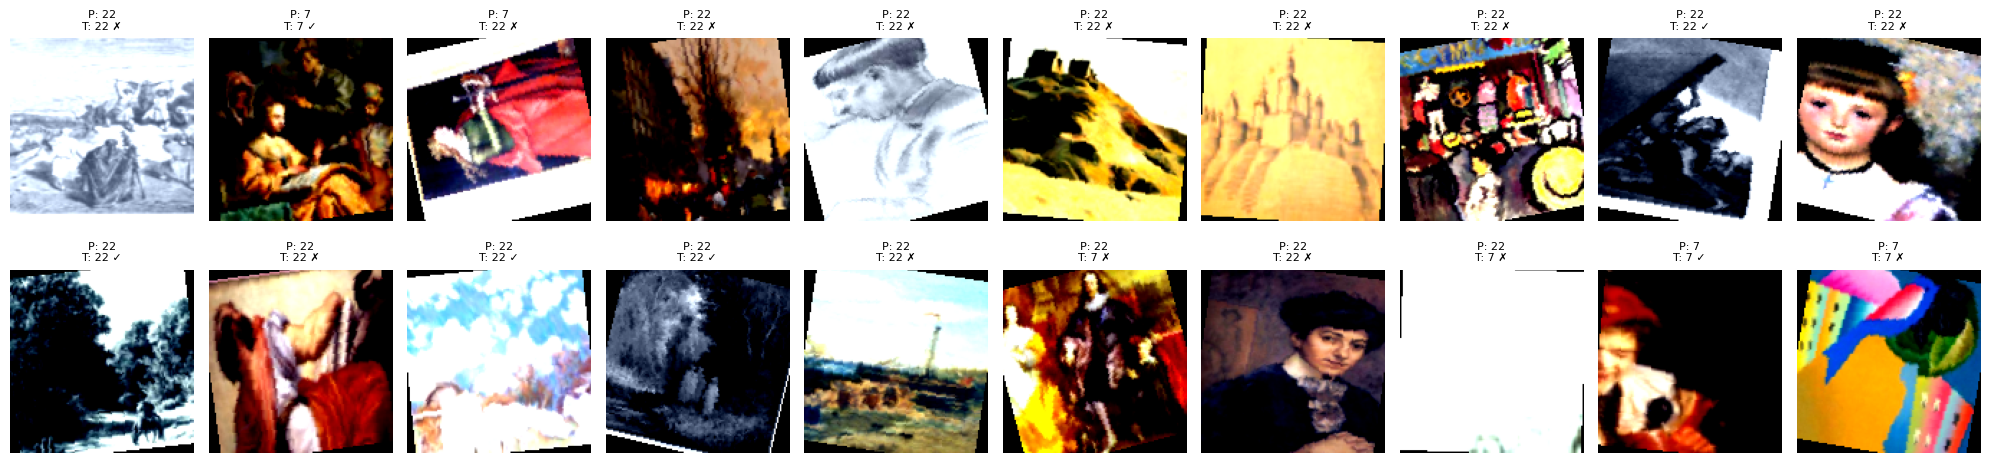

In [50]:
model.eval()
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
axes = axes.flatten()
classes = test_loader.dataset.labels
shown = 0

correct_total = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        correct_total += (preds == labels).sum().item()
        total += labels.size(0)
        print(f"predicted {preds}, ground truth {labels}")

        for i in range(images.size(0)):
            if shown >= 20:
                continue
            ax = axes[shown]
            img = images[i].cpu().permute(1, 2, 0)
            img = img * 0.5 + 0.5  # adjust if your normalization differs
            ax.imshow(img.numpy())
            correct = '✓' if preds[i] == labels[i] else '✗'
            ax.set_title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]} {correct}", fontsize=8)
            ax.axis('off')
            shown += 1

accuracy = 100.0 * correct_total / total
print(f'Test Accuracy: {accuracy:.2f}%')

plt.tight_layout()
plt.show()

Test Accuracy: 21.30%


<Figure size 2200x2000 with 0 Axes>

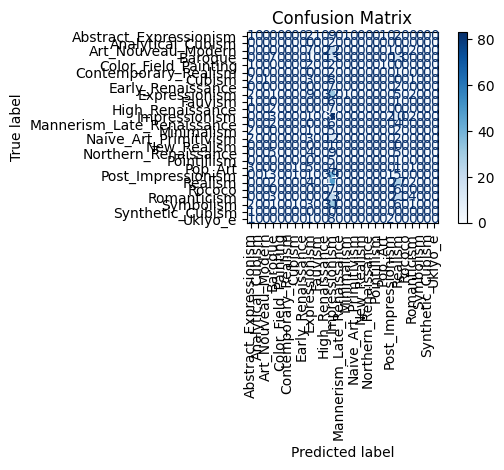

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes =test_loader.dataset.classes# Use the correct attribute for class names

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        correct_total += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100.0 * correct_total / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(22, 20))  # Increase size of the plot

disp.plot(xticks_rotation=90, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()